In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
alpha = 1.0
beta = 2.0
k = 5.0

N = 4

H = np.identity(2*N) * alpha

for i in range(2*N):
    for j in range(2*N):
        if i == j+1 or i == j-1:
            H[i,j] = beta
        elif i + j == 2*N-1:
            if j > N:
                if j % 2 == 0:
                    H[i,j] = beta
                else:
                    H[i,j] = -k
            else:
                if j % 2 == 1:
                    H[i,j] = beta
                else:
                    H[i,j] = k
            
H

array([[ 1.,  2.,  0.,  0.,  0.,  0.,  0., -5.],
       [ 2.,  1.,  2.,  0.,  0.,  0.,  2.,  0.],
       [ 0.,  2.,  1.,  2.,  0., -5.,  0.,  0.],
       [ 0.,  0.,  2.,  1.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2.,  1.,  2.,  0.,  0.],
       [ 0.,  0.,  5.,  0.,  2.,  1.,  2.,  0.],
       [ 0.,  2.,  0.,  0.,  0.,  2.,  1.,  2.],
       [ 5.,  0.,  0.,  0.,  0.,  0.,  2.,  1.]])

In [11]:
def diagonalize(N, hamiltonian_function):
    k_array = np.linspace(-np.pi/a, np.pi/a, 51)
    E_array = np.zeros((len(k_array), 2*N))
    
    for idx, k in enumerate(k_array):
        H = hamiltonian_function(N, alpha, beta, k)
        E_array[idx] = np.linalg.eigvalsh(H)
    
    return E_array

In [43]:
def make_NZZNT_hamiltonian(N, alpha, beta, k):

    H = np.identity(2*N, dtype=complex) * alpha

    for i in range(2*N):
        for j in range(2*N):
            if i == j+1 or i == j-1:
                H[i,j] = beta
            elif i + j == 2*N-1:
                if j > N:
                    if j % 2 == 0:
                        H[i,j] = beta
                    else:
                        H[i,j] = beta*np.exp(-1j*k*a)
                else:
                    if j % 2 == 1:
                        H[i,j] = beta
                    else:
                        H[i,j] = beta*np.exp(+1j*k*a)
    return H

In [44]:
alpha = 0.0
beta = 2.0
a = 1.0

k_array = np.linspace(-np.pi/a, np.pi/a, 51)

E_Z11 = diagonalize(N=11, hamiltonian_function=make_NZZNT_hamiltonian)

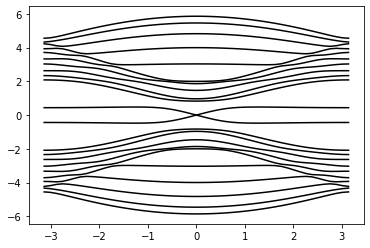

In [45]:
plt.plot(k_array, E_Z11, c='k')
plt.show()